In [1136]:
#### check data is correct(multi layer depth map), geometry valid, and visualze the joint (15 joints setting)
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import cv2
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
import mltools as ml
test_3d_gt_rel_std = np.load('test/test_3d_gt_rel_std.npy')
test_3d_gt_rel_mean = np.load('test/test_3d_gt_rel_mean.npy')
gt_3d_train_rel = np.load('train/gt_3d_train_rel.npy')
train_3d_gt_rel_std = np.load('train/train_3d_gt_rel_std.npy')
train_3d_gt_rel_mean = np.load('train/train_3d_gt_rel_mean.npy')
test_2d_gt_std = np.load('test/test_2d_gt_std.npy')
test_2d_gt_mean = np.load('test/test_2d_gt_mean.npy')
train_2d_gt_std = np.load('train/train_2d_gt_std.npy')
train_2d_gt_mean = np.load('train/train_2d_gt_mean.npy')
gt_2d_test = np.load('test/gt_2d_test.npy')
gt_2d_train = np.load('train/gt_2d_train.npy')
J_test_gt_mdp_enc2_15 = np.load('test/J_test_gt_mdp_enc2_15.npy')
J_train_gt_mdp_enc2_15 = np.load('train/J_train_gt_mdp_enc2_15.npy')
J_test_gt_mdp_15 = np.load('test/J_test_gt_mdp_15.npy')
J_train_gt_mdp_15 = np.load('train/J_train_gt_mdp_15.npy')
test_gt_mdp_15 = np.load('test/test_gt_mdp_15.npy')
train_gt_mdp_15 = np.load('train/train_gt_mdp_15.npy')
gt_2d_val = np.load('validation/gt_2d_val.npy')
gt_3d_val_rel = np.load('validation/gt_3d_val_rel.npy')
J_val_gt_mdp_15 = np.load("validation/J_val_gt_mdp_15.npy")
J_val_gt_mdp_enc2_15 = np.load("validation/J_val_gt_mdp_enc2_15.npy")
val_gt_mdp_15 = np.load("validation/val_gt_mdp_15.npy")

In [1137]:
print(test_3d_gt_rel_std.shape)
print(test_3d_gt_rel_mean.shape)
print(gt_3d_train_rel.shape)
print(train_3d_gt_rel_std.shape)
print(train_3d_gt_rel_mean.shape)
print(test_2d_gt_std.shape)
print(test_2d_gt_mean.shape)
print(train_2d_gt_std.shape)
print(train_2d_gt_mean.shape)
print(gt_2d_test.shape)
print(gt_2d_train.shape)
print(J_test_gt_mdp_enc2_15.shape)
print(J_train_gt_mdp_enc2_15.shape)
print(J_test_gt_mdp_15.shape)
print(J_train_gt_mdp_15.shape)
print(test_gt_mdp_15.shape)
print(train_gt_mdp_15.shape)
print(gt_2d_val.shape)
print(gt_3d_val_rel.shape)
print(J_val_gt_mdp_15.shape)
print(J_val_gt_mdp_enc2_15.shape)
print(val_gt_mdp_15.shape)

(45,)
(45,)
(222514, 15, 3)
(45,)
(45,)
(32,)
(32,)
(32,)
(32,)
(82378, 16, 2)
(222514, 16, 2)
(82378, 15, 64)
(222514, 15, 64)
(82378, 15, 15)
(222514, 15, 15)
(82378, 15, 15)
(222514, 15, 15)
(8000, 16, 2)
(8000, 15, 3)
(8000, 15, 15)
(8000, 15, 64)
(8000, 15, 15)


In [14]:
!pwd

/Users/bar/Desktop/Folder/hackathon


In [15]:
### data range, you may use the mean, std file to normalize the input and output, but remember to un-normalize for evaluation
print(np.max(gt_3d_train_rel))
print(np.min(gt_3d_train_rel))
print(np.max(gt_2d_test))
print(np.max(gt_2d_train))
print(np.min(gt_2d_test))
print(np.min(gt_2d_train))

1008.7862982946299
-1016.8448478979265
250.60824584960938
251.00762939453125
9.500163078308105
9.500030517578125


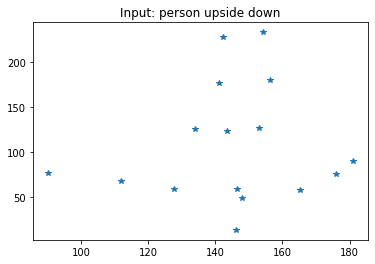

In [16]:
sample_id = 10
sample_2d = gt_2d_train[sample_id,...]
sample_3d = gt_3d_train_rel[sample_id,...]
plt.plot(sample_2d[:,0],sample_2d[:,1],'*')
plt.title('Input: person upside down')
plt.show()

Text(0.5, 1.0, 'Input: Person in 2d image space')

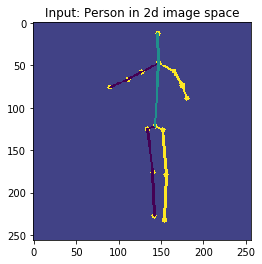

In [17]:
def show2D(points):
    points = ((points.reshape(16, -1))).astype(np.int32)
    img = np.ones((256,256)) * 50
    for j in range(16):
        if j == 7:
            continue
        img = cv2.circle(img, tuple(points[j, :].astype(int)), 3,  (255, 0, 0), cv2.FILLED)
    edges_left = [ [0,1], [1,2],[2,6],[10,11],[12,8],[11,12]]
    edges_middle = [[6, 8],[8, 9]]
    edges = [[0, 1], [1, 2], [2, 6], [6, 3], [3, 4], [4, 5],
         [10, 11], [11, 12], [12, 8], [8, 13], [13, 14], [14, 15],
         [6, 8], [8, 9]]
    for e in edges:
        if e in edges_left:  ## right and middle: red, left: blue
            cv2.line(img, (points[e[0], 0], points[e[0], 1]),
                  (points[e[1], 0], points[e[1], 1]), [0,0,255], 2)
        elif e in edges_middle:    
            cv2.line(img, (points[e[0], 0], points[e[0], 1]),
                  (points[e[1], 0], points[e[1], 1]), [128,0,128], 2)  
        else:
            cv2.line(img, (points[e[0], 0], points[e[0], 1]),
                  (points[e[1], 0], points[e[1], 1]), [255,0,0], 2) 
    return img
sample_2d_img = show2D(sample_2d)
plt.imshow(sample_2d_img)
plt.title('Input: Person in 2d image space')

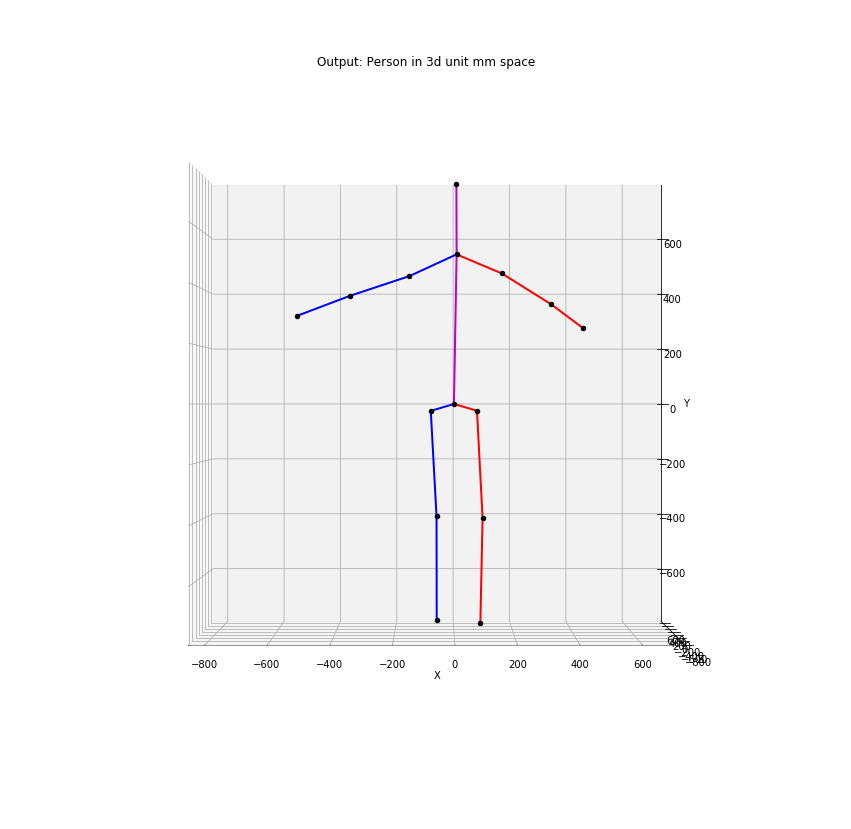

In [1018]:
def vis_3d_skeleton(kpt_3d_gt_old): 
    kpt_3d = np.zeros((16,3))
    kpt_3d[:6,:] = kpt_3d_gt_old[:6,:]
    kpt_3d[7:,:] = kpt_3d_gt_old[6:,:]
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(111, projection='3d')
    for j in range(16):
        if j == 7:
            continue
        ax.scatter(kpt_3d[j, 0], kpt_3d[j, 2], -kpt_3d[j, 1], c='k', marker='o')
    edges_left = [ [0,1], [1,2],[2,6],[10,11],[12,8],[11,12]]
    edges_middle = [[6, 8],[8, 9]]
    edges = [[0, 1], [1, 2], [2, 6], [6, 3], [3, 4], [4, 5],
             [10, 11], [11, 12], [12, 8], [8, 13], [13, 14], [14, 15],
             [6, 8], [8, 9]]
    for l in range(len(edges)):
        i1 = edges[l][0]
        i2 = edges[l][1]

        x2 = np.array([kpt_3d[i1, 0], kpt_3d[i2, 0]])
        y2 = np.array([kpt_3d[i1, 1], kpt_3d[i2, 1]])
        z2 = np.array([kpt_3d[i1, 2], kpt_3d[i2, 2]])        
        if edges[l] in edges_left:
            ax.plot(x2, z2, -y2, c='b', linewidth=2)
        elif edges[l] in edges_middle:    
            ax.plot(x2, z2, -y2, c='m', linewidth=2)
        else:
            ax.plot(x2, z2, -y2, c='r', linewidth=2)

    all_joints = kpt_3d
    all_joints[:, 1] *= -1
    bb_min = all_joints.min(axis=0)
    bb_max = all_joints.max(axis=0)
    bb_center = (bb_max + bb_min) * 0.5
    max_dist = np.abs(bb_max - bb_min).max() / 2
    bb_min, bb_max = bb_center - max_dist, bb_center + max_dist
    ax.set_xlim([bb_min[0], bb_max[0]])
    ax.set_ylim([bb_min[2], bb_max[2]])
    ax.set_zlim([bb_min[1], bb_max[1]])

    # Z and Y are swapped
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')

    ax.view_init(elev=11, azim=-82)
    plt.title('Output: Person in 3d unit mm space')

    #rotate the data by changing this
    ax.view_init(0, -90)
    plt.draw()

vis_3d_skeleton(sample_3d)

In [19]:
#### logistc regression, use samples to train and test
### I encourage you to try random forest as several paper in 3d human pose esitmation shows random forest gives good results
### but you have to think ways to incorporate geometry information [extra faetures]
X = np.reshape(gt_2d_train,(gt_2d_train.shape[0],16*2))
Y = np.reshape(gt_3d_train_rel,(gt_3d_train_rel.shape[0],15*3))
X_val = np.reshape(gt_2d_val,(gt_2d_val.shape[0],16*2))
Y_val = np.reshape(gt_3d_val_rel,(gt_3d_val_rel.shape[0],15*3))
print(X.shape)
print(Y.shape)
print(X_val.shape)
print(Y_val.shape)

(222514, 32)
(222514, 45)
(8000, 32)
(8000, 45)


In [1019]:
#loss function
#Our professer will use this to calculate the final score
def MPJPE_error(gt, pred):
    error =  (gt-pred) **2
    pjpe = np.sum(error,2) ** (1/2)
    mpjpe = np.mean(pjpe)
    return mpjpe

# Data Visulization

# Discovery 1

The model we are predicting are human. So they should have the same length of arms, legs, shouders and so on.

So I calculated some value and my guess is true.

However, I don't know what we can do to take advantage of this fact.

In [1025]:
def distanceSqar3D(p10,p11,p12,p20,p21,p22):
    return np.sqrt(kb.square(p10 - p11) + kb.square(p12 - p20) + kb.square(p21 - p22))

In [1026]:
#小腿
first = 0*3
second = 4*3
d_left = distanceSqar3D(Y[:,first], Y[:,first+3], Y[:,first+1], Y[:,first+1+3], Y[:,first+2], Y[:,first+2+3])
d_right = distanceSqar3D(Y[:,second], Y[:,second+3], Y[:,second+1], Y[:,second+1+3], Y[:,second+2], Y[:,second+2+3])
dmean = np.mean(np.sqrt((d_left - d_right)**2))
print("Difference between two legs:", dmean)

Difference between two legs: 2.6427365268750792e-05


In [1027]:
#大腿
first = 1*3
second = 3*3
d_left = distanceSqar3D(Y[:,first], Y[:,first+3], Y[:,first+1], Y[:,first+1+3], Y[:,first+2], Y[:,first+2+3])
d_right = distanceSqar3D(Y[:,second], Y[:,second+3], Y[:,second+1], Y[:,second+1+3], Y[:,second+2], Y[:,second+2+3])
dmean = np.mean(d_left - d_right)
print("Difference between two legs:", dmean)

Difference between two legs: -8.332049453835924e-08


In [1028]:
#小臂
first = 9*3
second = 13*3
d_left = distanceSqar3D(Y[:,first], Y[:,first+3], Y[:,first+1], Y[:,first+1+3], Y[:,first+2], Y[:,first+2+3])
d_right = distanceSqar3D(Y[:,second], Y[:,second+3], Y[:,second+1], Y[:,second+1+3], Y[:,second+2], Y[:,second+2+3])
dmean = np.mean(d_left - d_right)
print("Difference between two arms:", dmean)

Difference between two arms: 8.52816598894868e-08


In [1030]:
#大臂
first = 10*3
second = 12*3
d_left = distanceSqar3D(Y[:,first], Y[:,first+3], Y[:,first+1], Y[:,first+1+3], Y[:,first+2], Y[:,first+2+3])
d_right = distanceSqar3D(Y[:,second], Y[:,second+3], Y[:,second+1], Y[:,second+1+3], Y[:,second+2], Y[:,second+2+3])
dmean = np.mean(d_left - d_right)
print("Difference between two arms:", dmean)

Difference between two arms: 1.2882067756260924e-07


In [1031]:
#肩膀
six = 6*3
three = 11*3
four = 12*3
d_left = distanceSqar3D(Y[:,three], Y[:,six], Y[:,three+1], Y[:,six+1], Y[:,three+2], Y[:,six+2])
d_right = distanceSqar3D(Y[:,four], Y[:,six], Y[:,four+1], Y[:,six+1], Y[:,four+2], Y[:,six+2])
dmean = np.mean(d_left - d_right)
print("Difference between two shoulders:", dmean)

Difference between two shoulders: 1.239491754732918e-15


# Discovery 2

x, y for 2D is not the same as x, y for 3D

1. By printing out 2D and 3D graph, we can see they looks similiar, but not exact the same. So we have to predict x, y, z at the same time, not just z it self
2. We cannot manually rotate them, either, because different images are filmed in different directions

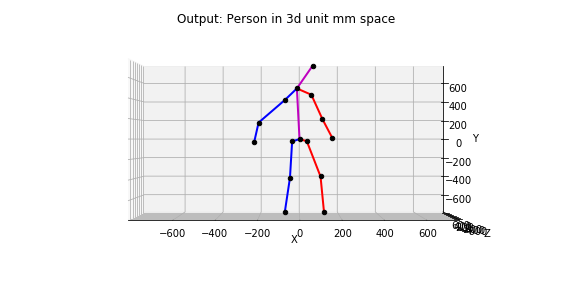

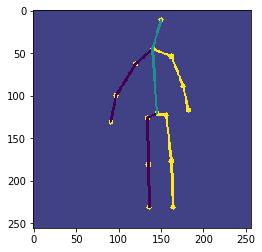

In [1062]:
my_vis_3d_skeleton(Y_reshape_back[122])
plt.show()
X_val_reshaped_img = show2D(X[122])
plt.imshow(X_val_reshaped_img)
plt.show()

In [1061]:
def my_vis_3d_skeleton(kpt_3d_gt_old): 
    kpt_3d = np.zeros((16,3))
    kpt_3d[:6,:] = kpt_3d_gt_old[:6,:]
    kpt_3d[7:,:] = kpt_3d_gt_old[6:,:]
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111, projection='3d')
    for j in range(16):
        if j == 7:
            continue
        ax.scatter(kpt_3d[j, 0], kpt_3d[j, 2], -kpt_3d[j, 1], c='k', marker='o')
    edges_left = [ [0,1], [1,2],[2,6],[10,11],[12,8],[11,12]]
    edges_middle = [[6, 8],[8, 9]]
    edges = [[0, 1], [1, 2], [2, 6], [6, 3], [3, 4], [4, 5],
             [10, 11], [11, 12], [12, 8], [8, 13], [13, 14], [14, 15],
             [6, 8], [8, 9]]
    for l in range(len(edges)):
        i1 = edges[l][0]
        i2 = edges[l][1]
        x2 = np.array([kpt_3d[i1, 0], kpt_3d[i2, 0]])
        y2 = np.array([kpt_3d[i1, 1], kpt_3d[i2, 1]])
        z2 = np.array([kpt_3d[i1, 2], kpt_3d[i2, 2]])        
        if edges[l] in edges_left:
            ax.plot(x2, z2, -y2, c='b', linewidth=2)
        elif edges[l] in edges_middle:    
            ax.plot(x2, z2, -y2, c='m', linewidth=2)
        else:
            ax.plot(x2, z2, -y2, c='r', linewidth=2)

    all_joints = kpt_3d
    all_joints[:, 1] *= -1
    bb_min = all_joints.min(axis=0)
    bb_max = all_joints.max(axis=0)
    bb_center = (bb_max + bb_min) * 0.5
    max_dist = np.abs(bb_max - bb_min).max() / 2
    bb_min, bb_max = bb_center - max_dist, bb_center + max_dist
    ax.set_xlim([bb_min[0], bb_max[0]])
    ax.set_ylim([bb_min[2], bb_max[2]])
    ax.set_zlim([bb_min[1], bb_max[1]])

    # Z and Y are swapped
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')

    ax.view_init(elev=11, azim=-82)
    plt.title('Output: Person in 3d unit mm space')
#     for angle in range(0, 360):
    ax.view_init(0, -90)
#     ax.grid(False)
    plt.draw()
#     plt.pause(.001)

# Training

# Linear Regression 2nd Poly of 561 features

In [1008]:
poly_2 = PolynomialFeatures(2, order = 'C')
poly_newX = poly_2.fit_transform(X)
print(poly_newX.shape)

(222514, 561)


In [1009]:
regr = linear_model.LinearRegression()
regr.fit(poly_newX, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [1013]:
Y_pred = regr.predict(poly_newX)
Y_pred_reshape = np.reshape(Y_pred,(Y_pred.shape[0],15,3))
print("training loss:", MPJPE_error(Y.reshape(-1,15,3),Y_pred_reshape))

Y_val_pred = regr.predict(poly_2.fit_transform((X_val)))
Y_val_pred_reshape = np.reshape(Y_val_pred,(Y_val_pred.shape[0],15,3))
print("validation loss", MPJPE_error(gt_3d_val_rel,Y_val_pred_reshape))

training loss: 75.14486106555218
validation loss 85.29656231121031


# Linear Regression 2nd Ploy of 65 features

In [1004]:
def PolyDegree2(nparr):
    return np.hstack((np.ones(nparr.shape[0]).reshape((-1,1)), nparr, np.square(nparr)))

In [1005]:
my_poly2_newX = PolyDegree2(X)
regr = linear_model.LinearRegression()
regr.fit(my_poly2_newX, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [1007]:
Y_pred = regr.predict(my_poly2_newX)
Y_pred_reshape = np.reshape(Y_pred,(Y_pred.shape[0],15,3))
print("training loss:", MPJPE_error(Y.reshape(-1,15,3),Y_pred_reshape))

Y_val_pred = regr.predict(PolyDegree2(X_val))
Y_val_pred_reshape = np.reshape(Y_val_pred,(Y_val_pred.shape[0],15,3))
print("validation loss", MPJPE_error(gt_3d_val_rel,Y_val_pred_reshape))

training loss: 102.60104123723387
validation loss 101.86806685429849


# Linear Regression 3rd Ploy of 97 features

In [1001]:
def PolyDegree3(nparr):
    return np.hstack((np.ones(nparr.shape[0]).reshape((-1,1)), nparr, np.square(nparr), np.power(nparr,3)))

In [1002]:
my_poly3_newX = PolyDegree3(X)
regr = linear_model.LinearRegression()
regr.fit(my_poly3_newX, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [1003]:
Y_pred = regr.predict(my_poly3_newX)
Y_pred_reshape = np.reshape(Y_pred,(Y_pred.shape[0],15,3))
print("training loss:", MPJPE_error(Y.reshape(-1,15,3),Y_pred_reshape))

Y_val_pred = regr.predict(PolyDegree3(X_val))
Y_val_pred_reshape = np.reshape(Y_val_pred,(Y_val_pred.shape[0],15,3))
print("validation loss", MPJPE_error(gt_3d_val_rel,Y_val_pred_reshape))

training loss: 97.18983053950926
validation loss 96.89555609146531


# Linear Regression 2nd Ploy of self-defined 561 features

if x=[a, b, c], ploy(x)=[1, a, b, c, a^2, b^2, c^2, (a^2-b^2)^1/2, (a^2-c^2)^1/2, (b^2-c^2)^1/2] 

very silly try, because this self-defined ploy has exact the same performance as the poly from the sklearn library

In [997]:
def myPolyDegree2(nparr):
    squares = np.square(nparr)
    minus = np.zeros((nparr.shape[0], nparr.shape[1]*(nparr.shape[1]-1)//2))
    index = 0
    for i in range(nparr.shape[1]):
        for j in range(i+1, nparr.shape[1]):
            minus[:,index] = np.square(nparr[:,i] - nparr[:,j])
            index += 1
    return np.hstack((np.ones(nparr.shape[0]).reshape((-1,1)), nparr, np.square(nparr), minus))

In [998]:
my_myPoly2_newX = myPolyDegree2(X)
regr = linear_model.LinearRegression()
regr.fit(my_myPoly2_newX, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [1000]:
Y_pred = regr.predict(my_myPoly2_newX)
Y_pred_reshape = np.reshape(Y_pred,(Y_pred.shape[0],15,3))
print("training loss:", MPJPE_error(Y.reshape(-1,15,3),Y_pred_reshape))

Y_val_pred = regr.predict(myPolyDegree2(X_val))
Y_val_pred_reshape = np.reshape(Y_val_pred,(Y_val_pred.shape[0],15,3))
print("validation loss", MPJPE_error(gt_3d_val_rel,Y_val_pred_reshape))

training loss: 75.14263145963959
validation loss 85.35487767999007


# Linear Regression 2nd Ploy of 1961 features

Add the data info of ray tracing

Still not good enough

In [ ]:
train_X = np.concatenate((scaler2.transform(ploy_X), 
                            scaler64.transform(J_train_gt_mdp_enc2_15.reshape((J_train_gt_mdp_enc2_15.shape[0],-1))), 
                            scaler15.transform(J_train_gt_mdp_15.reshape((J_train_gt_mdp_15.shape[0],-1))), 
                            scaler15d.transform(train_gt_mdp_15.reshape((train_gt_mdp_15.shape[0],-1)))),axis = 1)
train_Y = gt_3d_train_rel.reshape((gt_3d_train_rel.shape[0]),-1)
val_X = np.concatenate((scaler2.transform(ploy_val_X), 
                            scaler64.transform(J_val_gt_mdp_enc2_15.reshape((J_val_gt_mdp_enc2_15.shape[0],-1))), 
                            scaler15.transform(J_val_gt_mdp_15.reshape((J_val_gt_mdp_15.shape[0],-1))), 
                            scaler15d.transform(val_gt_mdp_15.reshape((val_gt_mdp_15.shape[0],-1)))),axis = 1)
val_Y = gt_3d_val_rel.reshape((gt_3d_val_rel.shape[0]),-1)

In [1015]:
regr = linear_model.LinearRegression()
regr.fit(train_X, train_Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [1017]:
Y_pred = regr.predict(train_X)
Y_pred_reshape = np.reshape(Y_pred,(Y_pred.shape[0],15,3))
print("training loss:", MPJPE_error(train_Y.reshape(-1,15,3),Y_pred_reshape))

Y_val_pred = regr.predict(val_X)
Y_val_pred_reshape = np.reshape(Y_val_pred,(Y_val_pred.shape[0],15,3))
print("validation loss", MPJPE_error(gt_3d_val_rel,Y_val_pred_reshape))

training loss: 72.29738254630814
validation loss 84.3675503058355


# Linear Regression 3rd Ploy of 6545 features

In [ ]:
#TODO: Try this on a better with better CPU

In [ ]:
#If it takes a very long time to run this block, try not to run the second one. It will take forever
poly_3 = PolynomialFeatures(3, order = 'C')
poly3_newX = poly_3.fit_transform(X[:200])
print(poly3_newX.shape)

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(poly_newX, Y)

In [ ]:
Y_pred = regr.predict(poly_newX)
Y_pred_reshape = np.reshape(Y_pred,(Y_pred.shape[0],15,3))
print("training loss:", MPJPE_error(Y.reshape(-1,15,3),Y_pred_reshape))

Y_val_pred = regr.predict(poly_2_inter_only.fit_transform(addfeatures(X_val)))
Y_val_pred_reshape = np.reshape(Y_val_pred,(Y_val_pred.shape[0],15,3))
print("validation loss", MPJPE_error(gt_3d_val_rel,Y_val_pred_reshape))

# Summary for linear regression model

Linear model does not have very good performance, and it is always underfitting

We need to try more complex models

In [1138]:
import numpy as np
import keras
import keras.backend as kb
import tensorflow as tf

In [1139]:
import os
from keras.models import model_from_json
from keras.layers import Dense

In [ ]:
#define my own loss function
#this is basically MSE, but we can change it as we need (such as adding a regularization)
def myLoss(real, pred):
    return kb.mean(kb.sum(kb.square((real-pred))))/1000000

In [ ]:
#write the loss function one more time for convinence
def MPJPE_error(gt, pred):
    error =  (gt-pred) **2
    pjpe = np.sum(error,2) ** (1/2)
    mpjpe = np.mean(pjpe)
    return mpjpe

In [1175]:
from sklearn.tree import DecisionTreeRegressor

AttributeError: type object 'sklearn.tree._criterion.array' has no attribute '__reduce_cython__'

In [1174]:
conda update scikit-learn

Solving environment: - 

Updating scikit-learn is constricted by 

anaconda -> requires scikit-learn==0.21.3=py37h27c97d8_0

If you are sure you want an update of your package either try `conda update --all` or install a specific version of the package you want using `conda install <pkg>=<version>`

done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


# Deep Learning Model 1

training loss = 65, validation loss = 79
这个model的train set没有包含 ray tracing 的数据，所以结果并不是很好，可以忽略

In [1078]:
print(model.summary())
print(model2.summary())
print(model3.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 561)               315282    
_________________________________________________________________
dense_38 (Dense)             (None, 150)               84300     
_________________________________________________________________
dense_39 (Dense)             (None, 45)                6795      
Total params: 406,377
Trainable params: 406,377
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_211 (Dense)            (None, 1971)              3886812   
_________________________________________________________________
dense_212 (Dense)            (None, 140)               276080    
___________________

In [ ]:
# You don't need to run this. This is just to show how I construct the model

# model = keras.Sequential([
#     keras.layers.Dense(561, activation=tf.nn.sigmoid),
#     keras.layers.Dense(150),
#     keras.layers.Dense(45)
#   ])

In [ ]:
#save the model

################### Do not run this before loading the model or having a better model##################

# model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("model.h5")

In [1070]:
#load the model

json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

In [1074]:
model = loaded_model

In [953]:
#change the traing X to the 2nd degree polynomial
ployX = myPolyDegree2(X)

In [471]:
from keras.regularizers import l2
from keras.layers import Dropout
model.add(Dense(45, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))

In [491]:
optimizer = tf.keras.optimizers.RMSprop(0.00002)
model.compile(loss=myLoss,optimizer=optimizer)
model.fit(ployX,Y,epochs=3)

Epoch 1/3
222514/222514 [==============================] - 22s 97us/step - loss: 3037629.9089
Epoch 2/3
222514/222514 [==============================] - 28s 126us/step - loss: 3036011.5740
Epoch 3/3
222514/222514 [==============================] - 28s 127us/step - loss: 3034253.5132


In [1068]:
#change the validation X to the 2nd degree polynomial

poly_X_val = myPolyDegree2(X_val)

In [1076]:
Y_val_pred = model.predict(poly_X_val)
Y_val_pred_reshape = np.reshape(Y_val_pred,(Y_val_pred.shape[0],15,3))
print("validation loss:",MPJPE_error(gt_3d_val_rel,Y_val_pred_reshape))

validation loss: 78.88045127442568


In [1077]:
Y_pred = model.predict(polyX)
Y_pred_reshape = np.reshape(Y_pred,(Y_pred.shape[0],15,3))
print("training loss:",MPJPE_error(Y.reshape((-1,15,3)),Y_pred_reshape))

training loss: 68.43869600880728


# Deep Learning Model 2

training loss = 32, validation loss = 70

但从Epoch中的loss结果可以看出， 这个model是可以找到training data的 global optimal的（或者说local optimal很优秀）
但是很明显会overfitting, 所以，可以尝试加一点regularization和dropout 去一下overfitting （估计可以达到validation loss <= 65 或更低）

不过要注意，
          optimizer = tf.keras.optimizers.RMSprop(0.0002)
中的 0.0002是learning rate， 这是数值在training的过程中是可以调整的（调整幅度大概在 0.05 - 0.00001)
一开始也不能太大 loss = 200+ 和 = 130+ 有两个很容易到的local optimal

In [ ]:
ploy_train_X = poly_test.fit_transform(gt_2d_train.reshape((gt_2d_train.shape[0],-1)))
ploy_val_X = poly_test.fit_transform(gt_2d_val.reshape((gt_2d_val.shape[0],-1)))

from sklearn.preprocessing import StandardScaler
scaler2 = StandardScaler()
scaler2.fit(ploy_X)
scaler64 = StandardScaler()
scaler64.fit(J_train_gt_mdp_enc2_15.reshape((J_train_gt_mdp_enc2_15.shape[0],-1)))
scaler15 = StandardScaler()
scaler15.fit(J_train_gt_mdp_15.reshape((J_train_gt_mdp_15.shape[0],-1)))
scaler15d = StandardScaler()
scaler15d.fit(train_gt_mdp_15.reshape((train_gt_mdp_15.shape[0],-1)))

In [ ]:
train_X = np.concatenate((scaler2.transform(ploy_X), 
                          scaler64.transform(J_train_gt_mdp_enc2_15.reshape((J_train_gt_mdp_enc2_15.shape[0],-1))), 
                          scaler15.transform(J_train_gt_mdp_15.reshape((J_train_gt_mdp_15.shape[0],-1))), 
                          scaler15d.transform(train_gt_mdp_15.reshape((train_gt_mdp_15.shape[0],-1)))),axis = 1)
train_Y = gt_3d_train_rel.reshape((gt_3d_train_rel.shape[0]),-1)
val_X = np.concatenate((scaler2.transform(ploy_val_X), 
                        scaler64.transform(J_val_gt_mdp_enc2_15.reshape((J_val_gt_mdp_enc2_15.shape[0],-1))), 
                        scaler15.transform(J_val_gt_mdp_15.reshape((J_val_gt_mdp_15.shape[0],-1))), 
                        scaler15d.transform(val_gt_mdp_15.reshape((val_gt_mdp_15.shape[0],-1)))),axis = 1)
val_Y = gt_3d_val_rel.reshape((gt_3d_val_rel.shape[0]),-1)

In [ ]:
#save model2 to local file

model2_json = model2.to_json()
with open("model2.json", "w") as json_file:
    json_file.write(model2_json)
model2.save_weights("model2.h5")

In [1125]:
#load model2 from the loacl file

json_file = open('model2.json', 'r')
loaded_model2_json = json_file.read()
json_file.close()
loaded_model2 = model_from_json(loaded_model2_json)
loaded_model2.load_weights("model2.h5")

In [1126]:
model2 = loaded_model2

In [657]:
#model 2 layer structure
#You don't need to run this
#如果想修改，例如+regularization 和dropout的话，可以run

# model2 = keras.Sequential([
#     keras.layers.Dense(1971, activation=tf.nn.sigmoid),
#     keras.layers.Dense(140),
#     keras.layers.Dense(45)
#   ])

In [644]:
#还是那句话，这个0.0002是可以调的
#我的经验是 0.002 先第一个epoch跑一半，然后换成 0.0002 一直跑
optimizer = tf.keras.optimizers.RMSprop(0.0002)
model2.compile(loss=myLoss,optimizer=optimizer)
model2.fit(train_X,train_Y,epochs=30)

Epoch 1/30
222514/222514 [==============================] - 360s 2ms/step - loss: 1.6772
Epoch 2/30
222514/222514 [==============================] - 346s 2ms/step - loss: 1.5375
Epoch 3/30
222514/222514 [==============================] - 328s 1ms/step - loss: 1.4298
Epoch 4/30
222514/222514 [==============================] - 345s 2ms/step - loss: 1.3448
Epoch 5/30
222514/222514 [==============================] - 359s 2ms/step - loss: 1.2747
Epoch 6/30
222514/222514 [==============================] - 349s 2ms/step - loss: 1.2171
Epoch 7/30
222514/222514 [==============================] - 337s 2ms/step - loss: 1.1701
Epoch 8/30
222514/222514 [==============================] - 352s 2ms/step - loss: 1.1274
Epoch 9/30
222514/222514 [==============================] - 356s 2ms/step - loss: 1.0915
Epoch 10/30
222514/222514 [==============================] - 325s 1ms/step - loss: 1.0595
Epoch 11/30
222514/222514 [==============================] - 323s 1ms/step - loss: 1.0312
Epoch 12/30
222514/

KeyboardInterrupt: 

In [1127]:
learning_rate = 0.0001
for i in range(50):
    if i % 5 == 4: 
        learning_rate = learning_rate/2
        print("Learning rate has been changed to:", learning_rate)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate)
    model2.compile(loss=myLoss,optimizer=optimizer)
    model2.fit(train_X,train_Y,epochs=1)
    Y_val_pred = model2.predict(val_X)
    Y_val_pred_reshape = np.reshape(Y_val_pred,(Y_val_pred.shape[0],15,3))
    print("validation loss:", MPJPE_error(gt_3d_val_rel,Y_val_pred_reshape))

Epoch 1/1
222514/222514 [==============================] - 385s 2ms/step - loss: 0.7152
validation loss: 68.32648804597177
Epoch 1/1
222514/222514 [==============================] - 404s 2ms/step - loss: 0.7034
validation loss: 68.32648804597177
Epoch 1/1
 25952/222514 [==>...........................] - ETA: 5:06 - loss: 0.6884

KeyboardInterrupt: 

In [1128]:
Y_val_pred = model2.predict(val_X)
Y_val_pred_reshape = np.reshape(Y_val_pred,(Y_val_pred.shape[0],15,3))
print("validation loss:", MPJPE_error(gt_3d_val_rel,Y_val_pred_reshape))

validation loss: 70.41012887955435


In [655]:
Y_val_pred = model2.predict(val_X)
Y_val_pred_reshape = np.reshape(Y_val_pred,(Y_val_pred.shape[0],15,3))
print("validation loss:", MPJPE_error(gt_3d_val_rel,Y_val_pred_reshape))

validation loss: 70.8466079111705


In [656]:
Y_pred = model2.predict(train_X)
Y_pred_reshape = np.reshape(Y_pred,(Y_pred.shape[0],15,3))
print("training loss:", MPJPE_error(Y.reshape((-1,15,3)),Y_pred_reshape))

training loss: 32.56014373829159


# Deep Learning Model 3  （still training）

In [914]:
from keras.layers import Dense
from keras.layers import Dropout
from keras.constraints import maxnorm

In [934]:
model3.layers.pop()
model3.layers.pop()
model3.layers.pop()
newModel = keras.Sequential([
    keras.layers.Dense(1971, activation=tf.nn.sigmoid, kernel_constraint=maxnorm(3), kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(140, kernel_constraint=maxnorm(3), kernel_regularizer=l2(0.01)),
    Dropout(0.2),
    Dense(45, kernel_constraint=maxnorm(3))
])
# newModel.add(Dense(1971, activation=tf.nn.sigmoid, kernel_constraint=maxnorm(3), kernel_regularizer=l2(0.01)))
# newModel.add(Dropout(0.2))
# newModel.add(Dense(140, kernel_constraint=maxnorm(3), kernel_regularizer=l2(0.01)))
# newModel.add(Dropout(0.2))
# newModel.add(Dense(45, kernel_constraint=maxnorm(3)))

In [879]:
train_X = np.concatenate((scaler2.transform(ploy_X), 
                          scaler64.transform(J_train_gt_mdp_enc2_15.reshape((J_train_gt_mdp_enc2_15.shape[0],-1))), 
                          scaler15.transform(J_train_gt_mdp_15.reshape((J_train_gt_mdp_15.shape[0],-1))), 
                          scaler15d.transform(train_gt_mdp_15.reshape((train_gt_mdp_15.shape[0],-1)))),axis = 1)
train_Y = gt_3d_train_rel.reshape((gt_3d_train_rel.shape[0]),-1)
val_X = np.concatenate((scaler2.transform(ploy_val_X), 
                        scaler64.transform(J_val_gt_mdp_enc2_15.reshape((J_val_gt_mdp_enc2_15.shape[0],-1))), 
                        scaler15.transform(J_val_gt_mdp_15.reshape((J_val_gt_mdp_15.shape[0],-1))), 
                        scaler15d.transform(val_gt_mdp_15.reshape((val_gt_mdp_15.shape[0],-1)))),axis = 1)
val_Y = gt_3d_val_rel.reshape((gt_3d_val_rel.shape[0]),-1)

In [1102]:
model3 = keras.Sequential([
    keras.layers.Dense(1971, activation=tf.nn.sigmoid, kernel_regularizer=l2(0.0005)),
    Dense(140, kernel_regularizer=l2(0.0005)),
    Dense(45, )
])

In [1135]:
#save model3 to local file

model3_json = model3.to_json()
with open("model3.json", "w") as json_file:
    json_file.write(model3_json)
model3.save_weights("model3.h5")

In [1109]:
#load model3 from the loacl file

json_file = open('model3.json', 'r')
loaded_model3_json = json_file.read()
json_file.close()
loaded_model3 = model_from_json(loaded_model3_json)
loaded_model3.load_weights("model3.h5")

In [1110]:
model3 = loaded_model3

In [1154]:
# Epoch 1/1
# 222514/222514 [==============================] - 548s 2ms/step - loss: 3.5754
# validation loss: 67.94765865940005
# Epoch 1/1
# 222514/222514 [==============================] - 521s 2ms/step - loss: 3.4793
# validation loss: 68.41605490881022
learning_rate = 0.0002
for i in range(50):
    if i % 5 == 4: 
        learning_rate = learning_rate/2
        print("Learning rate has been changed to:", learning_rate)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate)
    model3.compile(loss=myLoss,optimizer=optimizer)
    model3.fit(train_X,train_Y,epochs=1)
    Y_val_pred = model3.predict(val_X)
    Y_val_pred_reshape = np.reshape(Y_val_pred,(Y_val_pred.shape[0],15,3))
    print("validation loss:", MPJPE_error(gt_3d_val_rel,Y_val_pred_reshape))

Epoch 1/1
  3488/222514 [..............................] - ETA: 8:10 - loss: 3.0553

KeyboardInterrupt: 

In [1159]:
Y_val_pred = model3.predict(val_X)
Y_val_pred_reshape = np.reshape(Y_val_pred,(Y_val_pred.shape[0],15,3))
print("validation loss:", MPJPE_error(gt_3d_val_rel,Y_val_pred_reshape))

validation loss: 68.03366942202337


In [1160]:
Y_pred = model3.predict(train_X)
Y_pred_reshape = np.reshape(Y_pred,(Y_pred.shape[0],15,3))
print("training loss:", MPJPE_error(Y.reshape((-1,15,3)),Y_pred_reshape))

training loss: 50.56891441119874


In [1140]:
train_X = np.concatenate((scaler2.transform(ploy_X), 
                          scaler64.transform(J_train_gt_mdp_enc2_15.reshape((J_train_gt_mdp_enc2_15.shape[0],-1))), 
                          scaler15.transform(J_train_gt_mdp_15.reshape((J_train_gt_mdp_15.shape[0],-1))), 
                          scaler15d.transform(train_gt_mdp_15.reshape((train_gt_mdp_15.shape[0],-1)))),axis = 1)
train_Y = gt_3d_train_rel.reshape((gt_3d_train_rel.shape[0]),-1)
val_X = np.concatenate((scaler2.transform(ploy_val_X), 
                        scaler64.transform(J_val_gt_mdp_enc2_15.reshape((J_val_gt_mdp_enc2_15.shape[0],-1))), 
                        scaler15.transform(J_val_gt_mdp_15.reshape((J_val_gt_mdp_15.shape[0],-1))), 
                        scaler15d.transform(val_gt_mdp_15.reshape((val_gt_mdp_15.shape[0],-1)))),axis = 1)
val_Y = gt_3d_val_rel.reshape((gt_3d_val_rel.shape[0]),-1)

In [1141]:
model4 = keras.Sequential([
    keras.layers.Dense(1971, activation=tf.nn.sigmoid, kernel_regularizer=l2(0.0008)),
    Dense(140, kernel_regularizer=l2(0.0008)),
    Dense(45, )
])

In [1170]:
# Epoch 1/1
# 222514/222514 [==============================] - 548s 2ms/step - loss: 3.5754
# validation loss: 67.94765865940005
# Epoch 1/1
# 222514/222514 [==============================] - 521s 2ms/step - loss: 3.4793
# validation loss: 68.41605490881022
learning_rate = 0.00002
for i in range(50):
    if i % 3 == 2: 
        learning_rate = learning_rate/2
        print("Learning rate has been changed to:", learning_rate)
    optimizer = tf.keras.optimizers.RMSprop(learning_rate)
    model4.compile(loss=myLoss,optimizer=optimizer)
    model4.fit(train_X,train_Y,epochs=1)
    Y_val_pred = model4.predict(val_X)
    Y_val_pred_reshape = np.reshape(Y_val_pred,(Y_val_pred.shape[0],15,3))
    print("validation loss:", MPJPE_error(gt_3d_val_rel,Y_val_pred_reshape))

Epoch 1/1
222514/222514 [==============================] - 493s 2ms/step - loss: 2.8835
validation loss: 66.27418140593083
Epoch 1/1
222514/222514 [==============================] - 503s 2ms/step - loss: 2.8778
validation loss: 66.63453294935205
Learning rate has been changed to: 1e-05
Epoch 1/1
210656/222514 [===========================>..] - ETA: 26s - loss: 2.8623

KeyboardInterrupt: 

In [1171]:
Y_val_pred = model4.predict(val_X)
Y_val_pred_reshape = np.reshape(Y_val_pred,(Y_val_pred.shape[0],15,3))
print("validation loss:", MPJPE_error(gt_3d_val_rel,Y_val_pred_reshape))

validation loss: 66.21621543862155


In [1172]:
Y_pred = model4.predict(train_X)
Y_pred_reshape = np.reshape(Y_pred,(Y_pred.shape[0],15,3))
print("training loss:", MPJPE_error(Y.reshape((-1,15,3)),Y_pred_reshape))

KeyboardInterrupt: 

In [1166]:
#load model4 from the loacl file

json_file = open('model4.json', 'r')
loaded_model4_json = json_file.read()
json_file.close()
loaded_model4 = model_from_json(loaded_model4_json)
loaded_model4.load_weights("model4.h5")

In [1176]:
#save model4 to local file

model4_json = model4.to_json()
with open("model4.json", "w") as json_file:
    json_file.write(model4_json)
model4.save_weights("model4.h5")

In [1167]:
model4 = loaded_model4

In [ ]:
poly_test_x = poly_test.fit_transform(gt_2d_test)
test_X = np.concatenate((scaler2.transform(poly_test_x), 
                        scaler64.transform(J_test_gt_mdp_enc2_15.reshape((J_test_gt_mdp_enc2_15.shape[0],-1))), 
                        scaler15.transform(J_test_gt_mdp_15.reshape((J_test_gt_mdp_15.shape[0],-1))), 
                        scaler15d.transform(test_gt_mdp_15.reshape((test_gt_mdp_15.shape[0],-1)))),axis = 1)

In [18]:
### final submission
X_test = np.reshape(gt_2d_test,(gt_2d_test.shape[0],16*2))
Y_test_pred = regr.predict(X_test)
Y_test_pred_reshape = np.reshape(Y_test_pred,(Y_test_pred.shape[0],15,3))
#np.save('Hackthon_groupXXX_submission.npy',Y_test_pred_reshape)

In [276]:
### final submission
X_test = np.reshape(gt_2d_test,(gt_2d_test.shape[0],16*2))
Y_test_pred = model.predict(myPolyDegree2(X_test))
Y_test_pred_reshape = np.reshape(Y_test_pred,(Y_test_pred.shape[0],15,3))
#np.save('Hackthon_groupXXX_submission.npy',Y_test_pred_reshape)

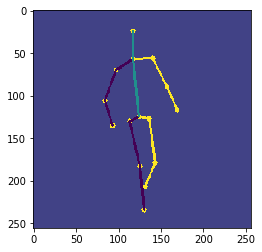

In [277]:
X_test_reshaped_img = show2D(X_val[6])
plt.imshow(X_test_reshaped_img)

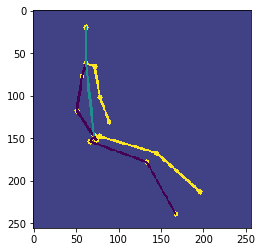

In [752]:
X_val_reshaped_img = show2D(X_val[0])
plt.imshow(X_val_reshaped_img)

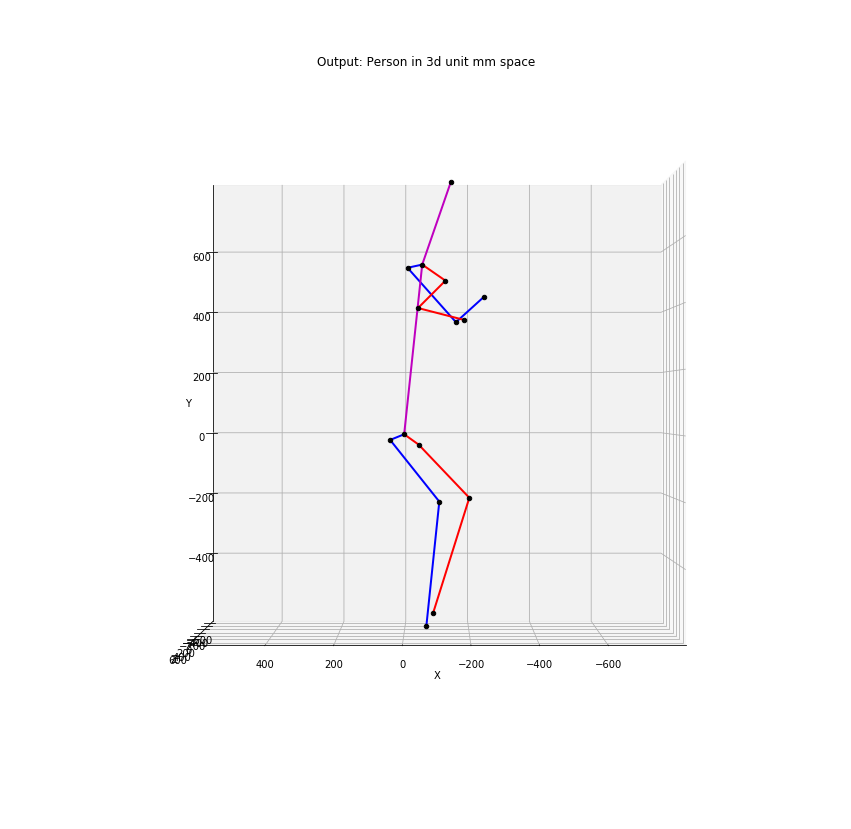

In [734]:
vis_3d_skeleton(Y_val_pred_reshape[1])

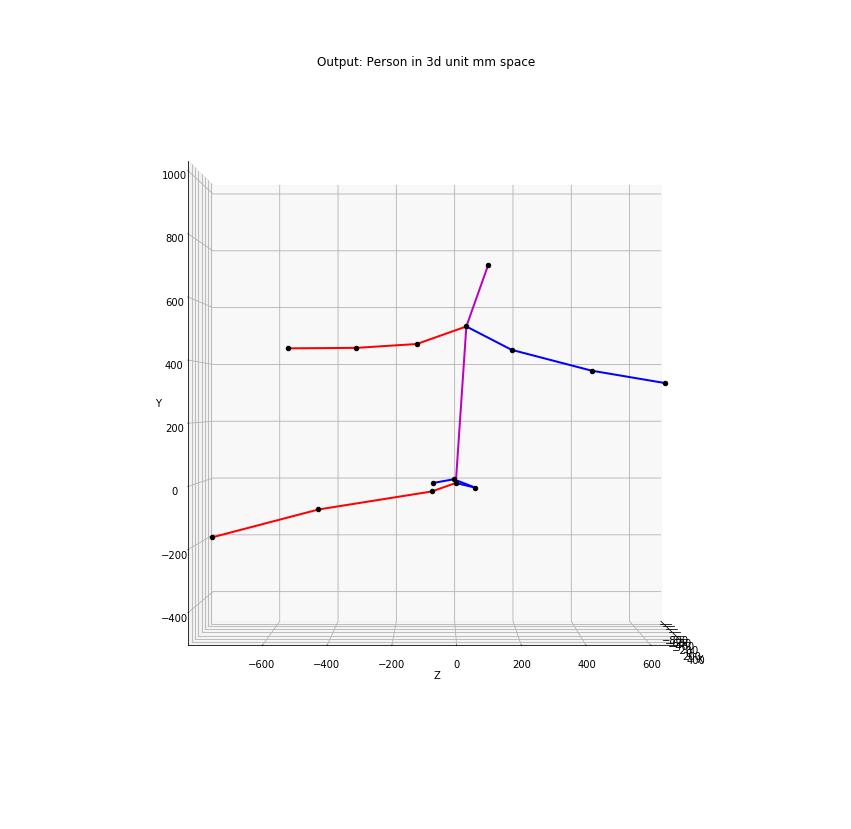

In [662]:
vis_3d_skeleton(gt_3d_val_rel[2])
# print(gt_3d_val_rel.shape)
# print(Y_test_pred_reshaped.shape)

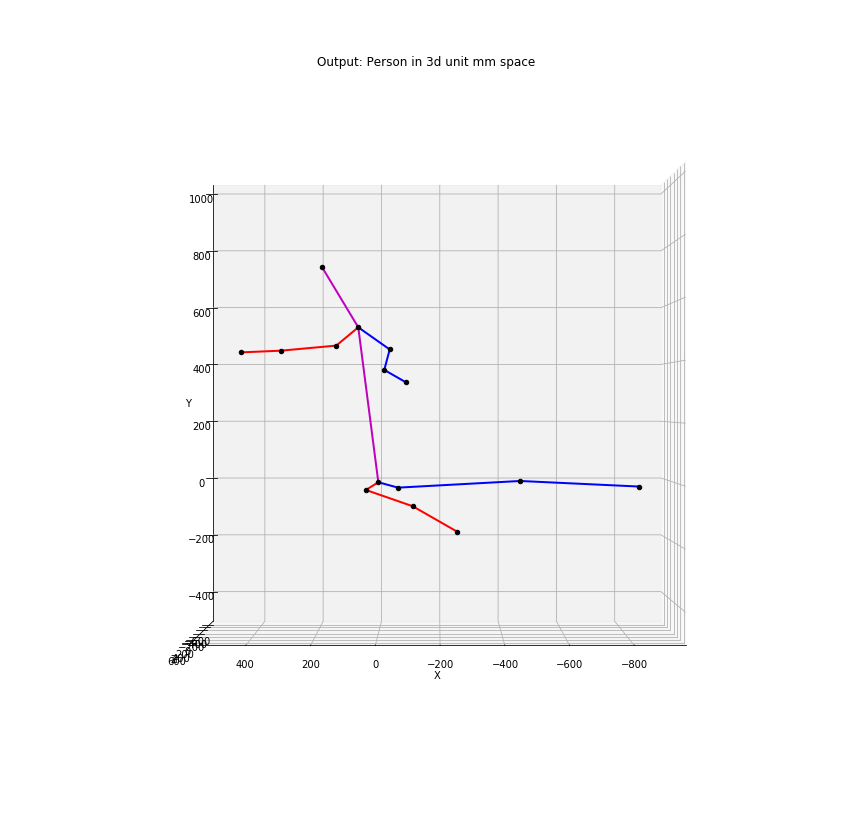

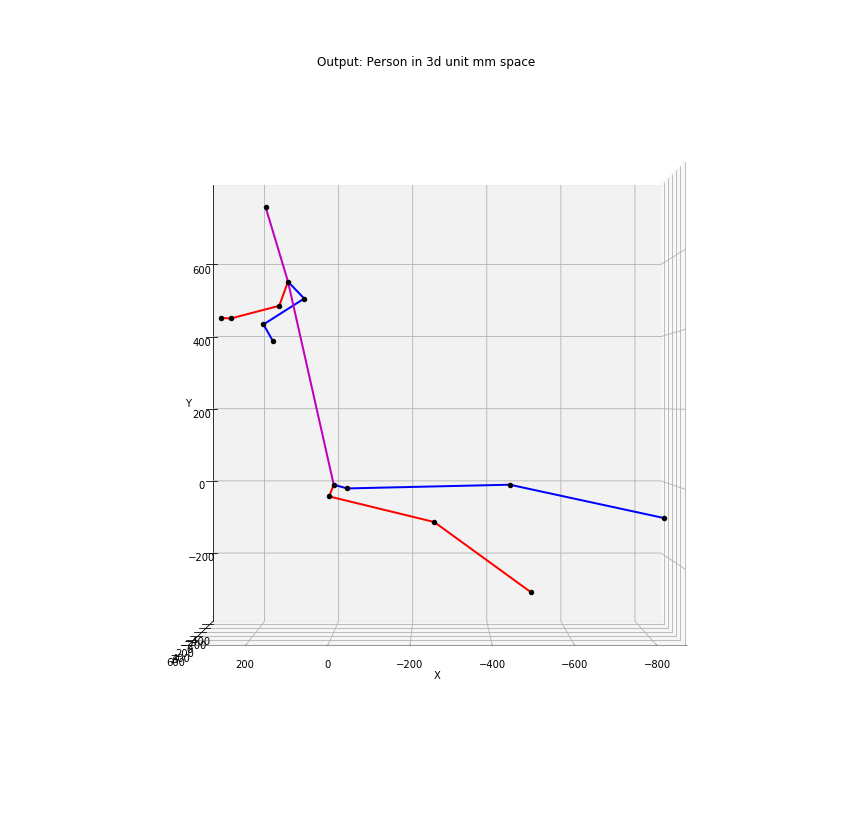

In [732]:
vis_3d_skeleton(gt_3d_val_rel[2])
vis_3d_skeleton(Y_val_pred_reshape[2])